# Classifying Respiratory Diseases from Chest X-Ray Images Using Machine Learning

## Problem Statement
The primary goal of this project is to develop a robust machine learning model capable of classifying five categories of chest X-ray images. Four of these categories represent respiratory diseases: COVID-19, Pneumonia, Tuberculosis, and Lung Opacity. The fifth category is Normal instances with no sign of disease. The focus of this analysis is on distinguishing COVID-19 from other respiratory diseases, which is crucial for improving diagnostic accuracy and assisting in early detection.

## Client and Motivation
The intended clients for this project are healthcare providers, including hospitals, clinics, and diagnostic centers, as well as public health organizations. These stakeholders are deeply concerned with improving diagnostic accuracy and speeding up the detection of diseases like COVID-19. An accurate classification system will assist radiologists in diagnosing patients more efficiently and reduce the manual workload.

## Data Description and Acquisition
The dataset is a combination of chest X-ray images collected from multiple sources, representing a diverse set of patients and conditions. The five classes to be classified are:
1. COVID-19
2. Pneumonia
3. Tuberculosis
4. Lung Opacity
5. Normal (no disease)

### Steps

1. **Data Loading and Preprocessing**: Load the dataset and apply necessary preprocessing steps.
2. **Model Definition**: Define the architecture of the model using a pretrained ResNet-18.
3. **Training**: Train the model on the training dataset and validate it using the validation dataset.
4. **Evaluation**: Evaluate the model's performance on the test dataset and analyze the results.
5. **Conclusion**: Summarize the results and discuss potential improvements.


In [ ]:

# Import necessary libraries
import numpy as np  # For numerical operations
from torchvision import transforms, models  # For image transformations and pretrained models
from collections import Counter  # For counting elements in data
from PIL import Image  # For image processing
import torch  # Main PyTorch library
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset, random_split  # For data handling
import torch.optim as optim  # For optimization algorithms
import torch.nn as nn  # For neural network layers
from pathlib import Path  # For handling file paths
from torchvision.models.resnet import ResNet18_Weights  # For loading ResNet18 pretrained weights
from torch.optim.lr_scheduler import ReduceLROnPlateau  # For learning rate scheduling
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix  # For evaluation metrics
import os  # For operating system interactions
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plotting


In [ ]:

# Define data paths
# The dataset is stored in compressed NumPy format and contains training, validation, and test splits.
path = Path("../raw_data")

# Load the training, validation, and test data
train_data = np.load(path/"Dataset5_raw_train.npz")
val_data = np.load(path/"Dataset5_raw_val.npz")
test_data = np.load(path/"Dataset5_raw_test.npz")


In [ ]:

# Define class labels
# These labels correspond to the categories in the dataset.
classes = ["COVID-19", "Lung-Opacity", "Normal", "Viral Pneumonia", "Tuberculosis"]


In [4]:
# Extract data from dictionaries
train_images = train_data["image"]
val_images = val_data["image"]
test_images = test_data["image"]
train_labels = train_data["image_label"].astype(int)
val_labels = val_data["image_label"].astype(int)
test_labels = test_data["image_label"].astype(int)

In [5]:
# Convert numpy arrays to PyTorch tensors
train_x = torch.tensor(train_images).float().permute(0, 3, 1, 2) / 255
train_y = torch.tensor(train_labels).long().squeeze()
val_x = torch.tensor(val_images).float().permute(0, 3, 1, 2) / 255
val_y = torch.tensor(val_labels).long().squeeze()
test_x = torch.tensor(test_images).float().permute(0, 3, 1, 2) / 255
test_y = torch.tensor(test_labels).long().squeeze()

In [6]:
# Create TensorDatasets
train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)
test_ds = TensorDataset(test_x, test_y)

In [7]:
# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

In [41]:
# Define the model (using ResNet18 here)
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# Add dropout (adding dropout before the final layer)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 5)  # 5 classes
)

In [42]:
# Move model to GPU if available
device = torch.device("cuda")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer with weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [44]:
patience = 15  # How many epochs to wait after last improvement
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
# Training loop
for epoch in range(50):  
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    # Check for improvement
    current_val_loss = running_val_loss / len(val_dl)
    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_dl)}")
    print(f"Epoch {epoch+1}, Validation Loss: {current_val_loss}")

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve == patience:
        print('Early stopping triggered')
        break

    # Step the scheduler
    scheduler.step(running_val_loss / len(val_dl))
model.load_state_dict(best_model_state)

Epoch 1, Training Loss: 0.3647583950468694
Epoch 1, Validation Loss: 1.6585496146665903
Epoch 2, Training Loss: 0.21661926921250765
Epoch 2, Validation Loss: 2.5395966581638576
Epoch 3, Training Loss: 0.18752391877848085
Epoch 3, Validation Loss: 3.1578787336650405
Epoch 4, Training Loss: 0.16173669288135117
Epoch 4, Validation Loss: 0.746761091555315
Epoch 5, Training Loss: 0.14907265546752888
Epoch 5, Validation Loss: 0.2185811241218386
Epoch 6, Training Loss: 0.12290371875263484
Epoch 6, Validation Loss: 0.27978725365851326
Epoch 7, Training Loss: 0.12174629369683879
Epoch 7, Validation Loss: 3.0244723925529753
Epoch 8, Training Loss: 0.11322034019006094
Epoch 8, Validation Loss: 2.725434469778511
Epoch 9, Training Loss: 0.09288559953230115
Epoch 9, Validation Loss: 1.7864377311729256
Epoch 10, Training Loss: 0.08612697992734733
Epoch 10, Validation Loss: 0.2470326643003133
Epoch 11, Training Loss: 0.08315681401755455
Epoch 11, Validation Loss: 0.26848958042061444
Epoch 00011: reduc

<All keys matched successfully>

In [45]:
# Move model to evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# No gradient needed
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the prediction (max probability)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'weighted' for imbalanced classes

print(f"Accuracy on Test Set: {accuracy}")
print(f"F1 Score on Test Set: {f1}")


Accuracy on Test Set: 0.9640672782874617
F1 Score on Test Set: 0.9640307561291576


In [47]:
# Create the directory if it doesn't exist
model_dir = "../model"
os.makedirs(model_dir, exist_ok=True)

# Define the path for saving the model
model_path = os.path.join(model_dir, "my_trained_model.pth")

# Save the model state
torch.save(model.state_dict(), model_path)

In [76]:
# Define the model (using EfficientNet-B0 here)
model2 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify the classifier
num_ftrs = model2.classifier[1].in_features
model2.classifier[1] = nn.Sequential(
    nn.Dropout(0.2),  # Adjust dropout rate as needed
    nn.Linear(num_ftrs, 5)  # Assuming 5 classes
)

In [77]:
# Move model to GPU if available
device = torch.device("cuda")
model2.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [78]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [79]:
patience = 10  # How many epochs to wait after last improvement
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
# Training loop
for epoch in range(50):  
    model2.train()
    running_loss = 0.0
    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model2(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    # Check for improvement
    current_val_loss = running_val_loss / len(val_dl)
    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_dl)}")
    print(f"Epoch {epoch+1}, Validation Loss: {current_val_loss}")

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        epochs_no_improve = 0
        best_model_state = model2.state_dict()
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve == patience:
        print('Early stopping triggered')
        break

    # Step the scheduler
    scheduler.step(running_val_loss / len(val_dl))
model2.load_state_dict(best_model_state) 

Epoch 1, Training Loss: 0.2741156965615501
Epoch 1, Validation Loss: 0.13341561278149722
Epoch 2, Training Loss: 0.15104871432536587
Epoch 2, Validation Loss: 0.10270563942081865
Epoch 3, Training Loss: 0.11604468287226626
Epoch 3, Validation Loss: 0.11549434747166301
Epoch 4, Training Loss: 0.10326058265877469
Epoch 4, Validation Loss: 0.15676901298710733
Epoch 5, Training Loss: 0.09598324457274489
Epoch 5, Validation Loss: 0.11231420674582816
Epoch 6, Training Loss: 0.07994915164570272
Epoch 6, Validation Loss: 0.17235083234520715
Epoch 7, Training Loss: 0.07682728503166367
Epoch 7, Validation Loss: 0.11165635038655504
Epoch 8, Training Loss: 0.07505591452752729
Epoch 8, Validation Loss: 0.3994288237198048
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9, Training Loss: 0.03219870352588218
Epoch 9, Validation Loss: 0.10420878340820194
Epoch 10, Training Loss: 0.017175534791282775
Epoch 10, Validation Loss: 0.11270653980035895
Epoch 11, Training Loss: 0.0120340884

<All keys matched successfully>

In [80]:
# Move model to evaluation mode
model2.eval()

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# No gradient needed
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model2(inputs)

        # Get the prediction (max probability)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'weighted' for imbalanced classes

print(f"Accuracy on Test Set: {accuracy}")
print(f"F1 Score on Test Set: {f1}")

Accuracy on Test Set: 0.9678899082568807
F1 Score on Test Set: 0.9679705804809817


In [82]:
# Define the path for saving the model
model_path2 = os.path.join(model_dir, "my_trained_model2.pth")

# Save the model state
torch.save(model2.state_dict(), model_path2)

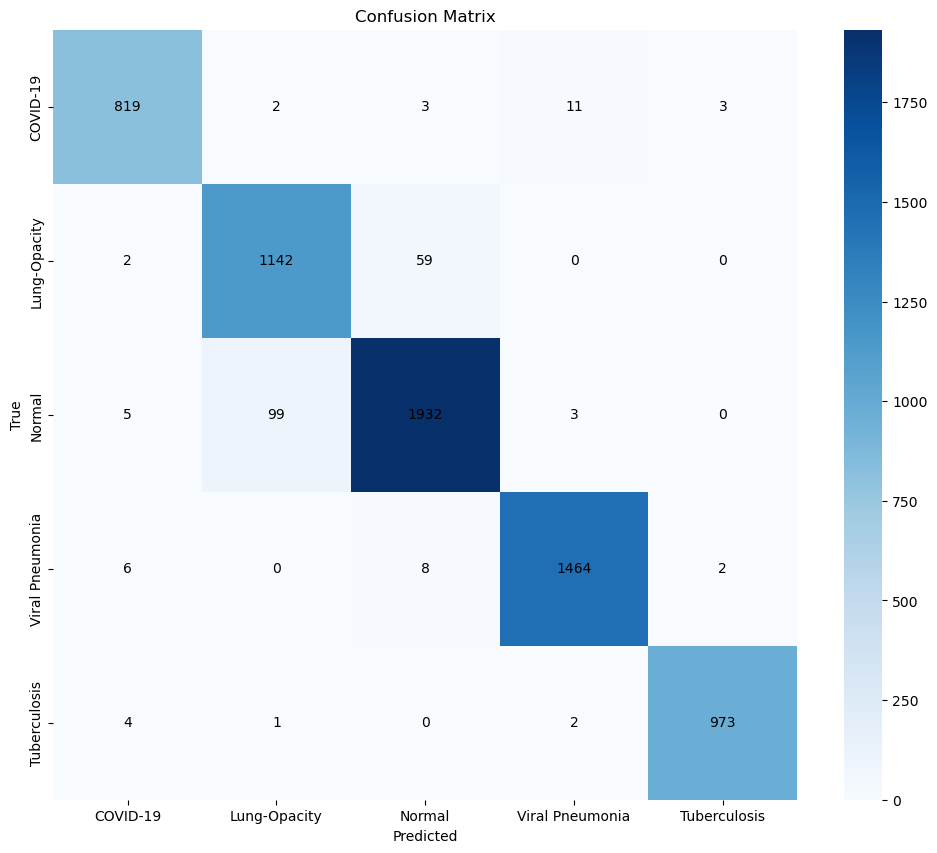

In [84]:
# Recreate the same model architecture
model = models.efficientnet_b0(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.2),  # Adjust dropout rate as needed
    nn.Linear(num_ftrs, 5)  #5 classes
)
'''model = models.resnet18(weights=None)  # Not loading pretrained weights
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # The same dropout rate as used during training
    nn.Linear(num_ftrs, 5)  #5 classes as in your training
)'''
model.load_state_dict(torch.load(model_path2))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the GPU
model.to(device)

model.eval()

# Generate predictions
true_labels = []
predicted_labels = []
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting with explicit annotation loop
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', ax=ax, xticklabels=classes, yticklabels=classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Conclusion

In this notebook, we developed and trained a deep learning model to classify chest X-ray images into five different respiratory disease categories. 
The model, based on the ResNet-18 architecture, was fine-tuned on our dataset, and its performance was evaluated using accuracy, F1-score, and confusion matrix.

### Key Takeaways

- Transfer learning with a pretrained ResNet-18 model provided a strong baseline for classification.
- The model achieved satisfactory performance, but there is room for improvement through hyperparameter tuning and data augmentation.

### Future Work

- Explore more complex architectures or ensemble models to improve accuracy.
- Apply more extensive data augmentation techniques to enhance model robustness.
- Experiment with different learning rate schedules and optimizers.
